# Homework -- Sequential Learning

Pierre Gaillard -- Jan. 2025

Students: Guillaume Lévy & Augustin Cablant


# Part 1. Porfolio Selection



The objective of this homework is to implement from scratch several algorithms from the class to select a portfolio. 
Given an initial capital $\mathrm{Cap}_0 > 0$, a trader repeatedly distributes her capital over $d$ assets with the goal of maximizing the total return. At each round $t=1,\dots, T$, the trader chooses an allocation $w_t \in \Delta_d:= \{\theta \in \mathbb{R}^d_+, \|\theta\|_1 = 1\}$. Here, $w_t(i)$ represents the share of capital invested into asset $i \in [d]$ at this round. At the end of the round, the returns (the ratios of the closing and opening prices of all assets in this round) are revealed in the form of $r_t \in \mathbb{R}^d_+$ and the trader's capital is updated as
$$
    \mathrm{Cap}_t = \mathrm{Cap}_{t-1} \langle w_t, r_t \rangle \,.
$$
The performance of a strategy that selected portfolios $(w_t)$ is quantified by comparing the final capital $\mathrm{Cap}_T$ against
$$
    \mathrm{Cap}_T^* =  \mathrm{Cap}_0 \max_{w \in \Delta_d} \prod_{t=1}^T \langle w, r_t\rangle \,,
$$
the idealized final capital attained by the best static strategy constrained to select the same rebalanced portfolio in all rounds. Due to the multiplicative structure, to maximize the capital it is natural to maximize the ratio $\mathrm{Cap}_T/ \mathrm{Cap}_T^*$, which is equivalent to minimizing the regret
$$
    \mathrm{Reg}_T := \sum_{t=1}^T \ell_t(w_t) - \min_{w \in \Delta_d} \sum_{t=1}^T \ell_t(w) = - \log \frac{\mathrm{Cap}_T}{\mathrm{Cap}_T^*} \,,
$$
where $\ell_t(w) := - \log \langle w, r_t\rangle$. In the following, we assume that the trader starts with $\mathrm{Cap}_0 = \$1$.


## Datasets


The folder `data` contains six datasets from financial markets: Dow Jones (DJIA), Morgan Stanley Capital International (MSCI), New York Stock Exchange (NYSE), Standard \& Poor's 500 Index (S\&P 500), and Toronto Stock Exchange (TSE). In these datasets, each row corresponds to a vector of price ratios, denoted as $r_t$. In other words, if $x$ dollars are invested in asset $k$ on day $t$, the trader's capital is updated to $x \cdot r_t(k)$.

| Dataset    | Region | Time Frame                          | # Periods | # Assets |
|------------|--------|--------------------------------------|-----------|----------|
| NYSE (O)   | USA    | July 3, 1962 – December 31, 1984    | 5651      | 36       |
| NYSE (N)   | USA    | January 1, 1985 – June 30, 2010     | 6431      | 23       |
| TSE        | CA     | January 4, 1994 – December 31, 1998 | 1259      | 88       |
| SP500      | USA    | January 2, 1998 – January 31, 2003  | 1276      | 25       |
| MSCI       | Global | April 1, 2006 – March 31, 2010      | 1043      | 24       |
| DJIA       | USA    | January 14, 2001 – January 14, 2003 | 507       | 30       |



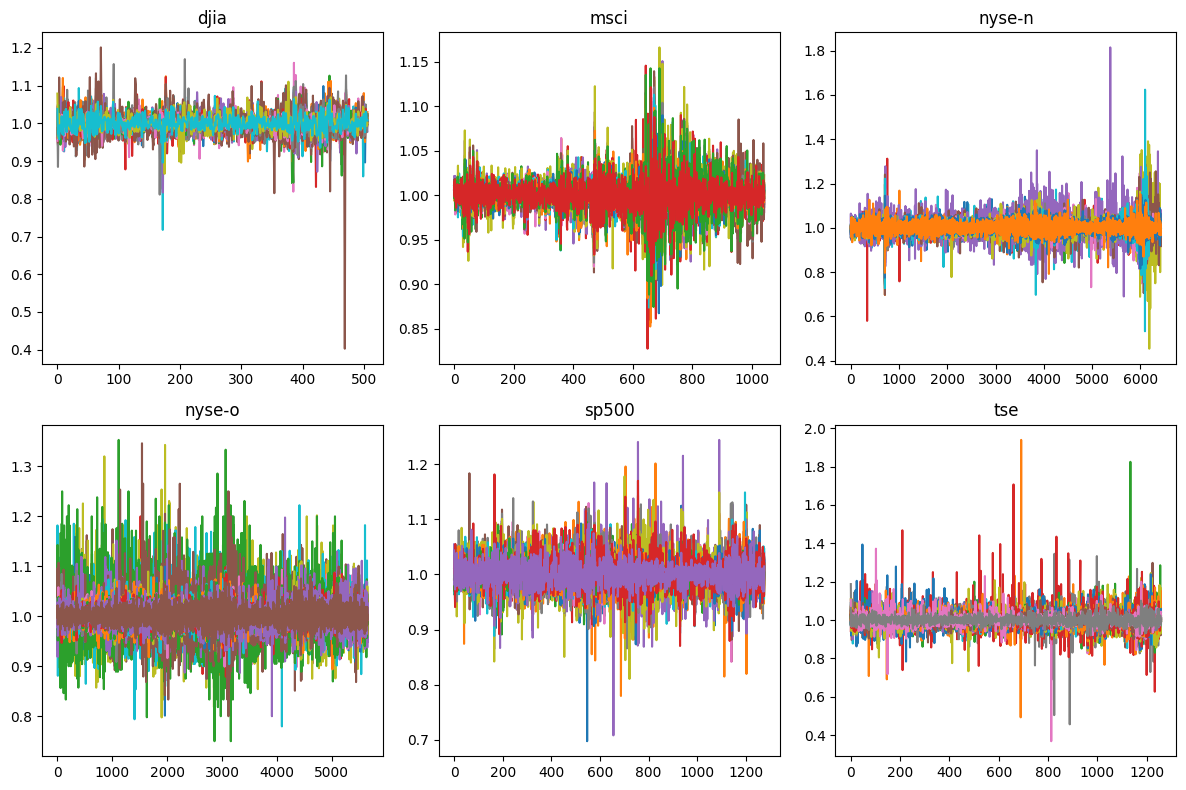

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
data = {}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
axes = axes.flatten()
for i in range(6):
    name = data_names[i]
    data[name] = pd.read_csv("data/"+name+".csv",header = None) 
    axes[i].plot(data[name]) 
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

### Question 1

Display a table that shows for each dataset:
* the final capital $\max_{k} \prod_{t=1}^T r_t(k)$ obtained by the trader if he had chosen the best fixed asset;
* the final capital $\mathrm{Cap_T^*}$ obtained by the trader if he had chosen the best fixed rebalanced portfolio (you may use convex optimisation libraries).

In [2]:
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
for i in range(6):
    name = data_names[i]
    dataset = pd.read_csv("data/"+name+".csv",header = None) 
    print(f"Total NaN for dataset {name}:", dataset.isna().sum().sum())

Total NaN for dataset djia: 0
Total NaN for dataset msci: 0
Total NaN for dataset nyse-n: 0
Total NaN for dataset nyse-o: 0
Total NaN for dataset sp500: 0
Total NaN for dataset tse: 0


The optimization consists in : $w^* = \text{argmax} \prod _{t=1} ^{T} w^{T} r_t$ such that $w \geq 0$ and $ \sum w_i = 1$.

In [3]:
import cvxpy as cp  # convec optimisation library

data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]
best_fixed_asset_capital = []
best_fixed_rebalanced_portfolio = []

for i in range(6):
    name = data_names[i]
    dataset = pd.read_csv("data/"+name+".csv",header = None) 
    T, k = dataset.shape
    dataset1 = dataset.copy()
    dataset2 = dataset.copy()

    # First part of the question
    dataset1.loc["final_capital"] = dataset1.prod(axis=0)
    best_fixed_asset_capital.append(dataset1.loc["final_capital"].max())

    # Second part of the question
    w = cp.Variable(k)  
    constraints = [cp.sum(w) == 1, w >= 0]
    R = dataset2.to_numpy()
    objective = cp.Maximize(cp.sum(cp.log(R @ w)))
    problem = cp.Problem(objective=objective, constraints=constraints)
    problem.solve(verbose=False)
    w_star = w.value
    best_fixed_rebalanced_portfolio.append(np.prod(R @ w_star))

df = pd.DataFrame(
    index=data_names, 
    columns=["best_fixed_asset_capital", "best_fixed_rebalanced_portfolio"], 
    data=list(zip(best_fixed_asset_capital, best_fixed_rebalanced_portfolio))
)
df

/opt/anaconda3/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


best_fixed_asset_capital  best_fixed_rebalanced_portfolio
djia                    1.188360                         1.239928
msci                    1.504023                         1.505693
nyse-n                 83.506698                       120.320907
nyse-o                 54.140364                       250.585000
sp500                   3.779182                         4.068627
tse                     6.279220                         6.779988

In [4]:
from scipy.optimize import minimize

def best_fixed_asset(data):
    ratios = data.iloc[-1] / data.iloc[0]
# Trouver la valeur maximale parmi ces ratios
    max_ratio = ratios.max()
    return max_ratio


def best_fixed_portfolio(data):
    def objective(w):
        return -np.sum(np.log(np.dot(data, w)))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1) for _ in range(data.shape[1])]
    
    result = minimize(objective, np.ones(data.shape[1])/data.shape[1], method='SLSQP', bounds=bounds, constraints=constraints)
    return np.exp(-result.fun)

results = []
for name in data_names:
    df = data[name]
    results.append({
        'Dataset': name,
        'Best Fixed Asset': best_fixed_asset(df),
        'Best Fixed Portfolio': best_fixed_portfolio(df)
    })

table = pd.DataFrame(results)
display(table)

Dataset  Best Fixed Asset  Best Fixed Portfolio
0    djia          1.048764              1.239928
1    msci          1.015142              1.505693
2  nyse-n          1.043245            120.320909
3  nyse-o          1.071432            250.597075
4   sp500          1.061978              4.068627
5     tse          1.079360              6.779987

### Question 2
Implement the update rule of the exponentially weighted average algorithm, that takes the current weight vector $w_t$, the vector $r_r$ and a learning rate and return the new weight vector.

In [5]:
def EWA_update(eta, w, r):
  # eta: learning rate
  # p: an np.array of shape (d,); vector of weights in Delta_d; to be updated
  # r: an np.array of shape (d,); vector of price ratios
  # Returns: an np.array of shape (d,); 

  # ---
  w_updated = w * np.exp(eta * r)
  w_updated /= np.sum(w_updated)
  # ---

  return w_updated

### Question 3 - EWA

Use EWA_update to select you portfolio sequentially.

In [6]:
capital_ewa = {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_EWA(name, T, capital, eta=1, plot_w=False):
    # Initialize the weights
    w = np.full(d, 1/d)  # w_1 of dimension d
    evolution_w = []
    evolution_w.append(w)
    for day in range(T):  # over horizon T
        # Update capital
        prices = data[name].loc[day, :].to_numpy()
        capital[name] *= np.sum(w * prices)
        # Update the weight vector to redistribute the capital for the next day
        w, r = w, prices
        w =  EWA_update(eta=eta, w=w, r=r)
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital_ewa

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    #eta = np.sqrt(np.log(d) / T)
    capital_ewa[name] = 1  # initial capital
    capital_ewa = use_EWA(name=name, T=T, capital=capital_ewa, eta=1, plot_w=False)


display(capital_ewa)

{'djia': 0.7627947568240975,
 'msci': 0.9043979758940479,
 'nyse-n': 20.889758505158536,
 'nyse-o': 9.75255131526772,
 'sp500': 1.3277755190322211,
 'tse': 1.4946097475465345}

### Question 4

a) What is the best theoretical value for eta ? 

b) Plot for the `djia` dataset the evolution of the weights for the theoretical value of eta and a well-chosen value (tuned by hand to minimize the final error).

Question 4-a: The best theorical value for eta is $ \eta = \sqrt{ \frac{ \log d}{T}}$. For this value, EWA satisfies the regret bound $ \mathcal{Reg} _T \leq 2 \sqrt{T \log d}$. 

In [7]:
capital_ewa_theorical_opt = {}

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    eta_opt = np.sqrt(np.log(d) / T)
    capital_ewa_theorical_opt[name] = 1  # initial capital
    capital_ewa_theorical_opt = use_EWA(name=name, T=T, capital=capital_ewa_theorical_opt, eta=eta_opt, plot_w=False)

display(capital_ewa_theorical_opt)

{'djia': 0.7627947568240975,
 'msci': 0.9257232837190059,
 'nyse-n': 31.120621624077966,
 'nyse-o': 27.115476905606346,
 'sp500': 1.633412988272723,
 'tse': 1.592678232167255}

Question 4-b:

Eta optimal is equal to:  0.08190528736261762


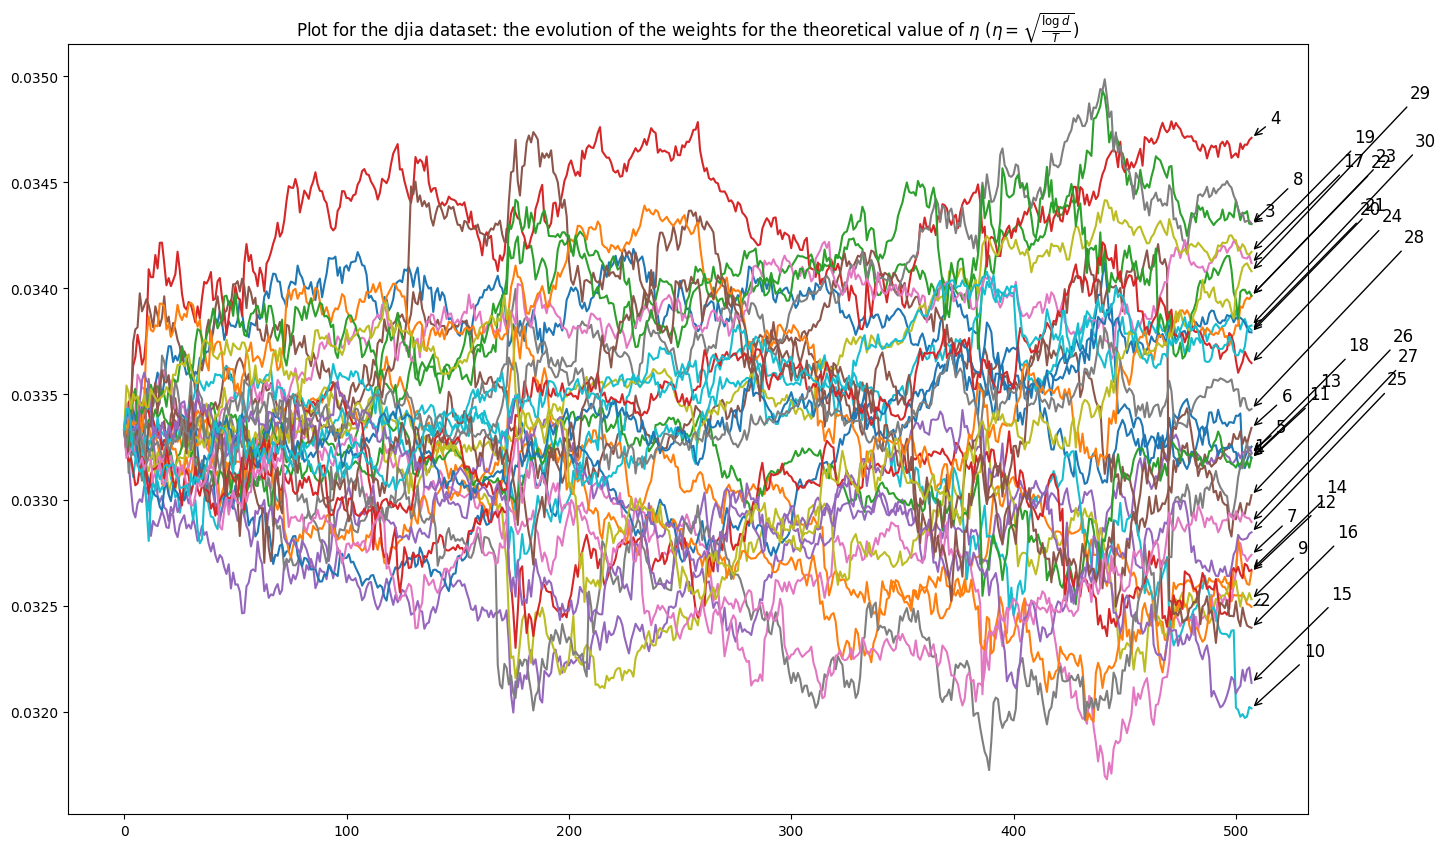

Final Capital: 0.8172607862617847


In [8]:
capital_ewa_djia = {}
name = "djia"
T, d = data[name].shape  # horizon, number of assets
eta_opt = np.sqrt(np.log(d) / T)
print("Eta optimal is equal to: ", eta_opt)
capital_ewa_djia[name] = 1  # initial capital
capital_ewa_djia, w_djia = use_EWA(name=name, T=T, capital=capital_ewa_djia, eta=eta_opt, plot_w=True)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the theoretical value of $\eta$ ($\eta = \sqrt{\frac{\log d}{T}}$)")
plt.show()

def final_capital(df, weights, verbose=True): 
    capital = 1 
    T, d = data["djia"].shape
    for t in range(T):
        capital *= np.dot(weights, df.iloc[t].values)
    if verbose:
        print("Final Capital:", capital)
    return capital

capital = final_capital(data["djia"], w_djia[-1])

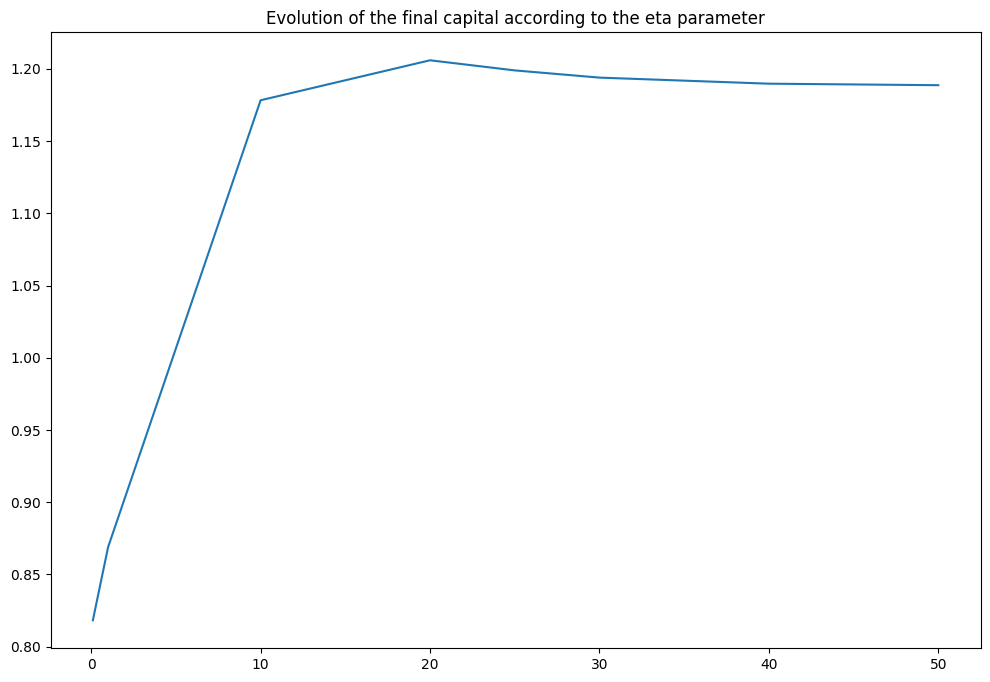

In [9]:
capitals = []
name = "djia"
T, d = data[name].shape  # horizon, number of assets
etas = [0.1, 1, 10, 20, 25, 30, 40, 50]
capital = []
for eta in etas:
    capital_ewa_djia[name] = 1  # initial capital
    _, w = use_EWA(name=name, T=T, capital=capital_ewa_djia, eta=eta, plot_w=True)
    cap = final_capital(data["djia"], w[-1], verbose=False)
    capitals.append(cap)

plt.figure(figsize=(12,8))
plt.plot(etas, capitals)
plt.title("Evolution of the final capital according to the eta parameter")
plt.show()

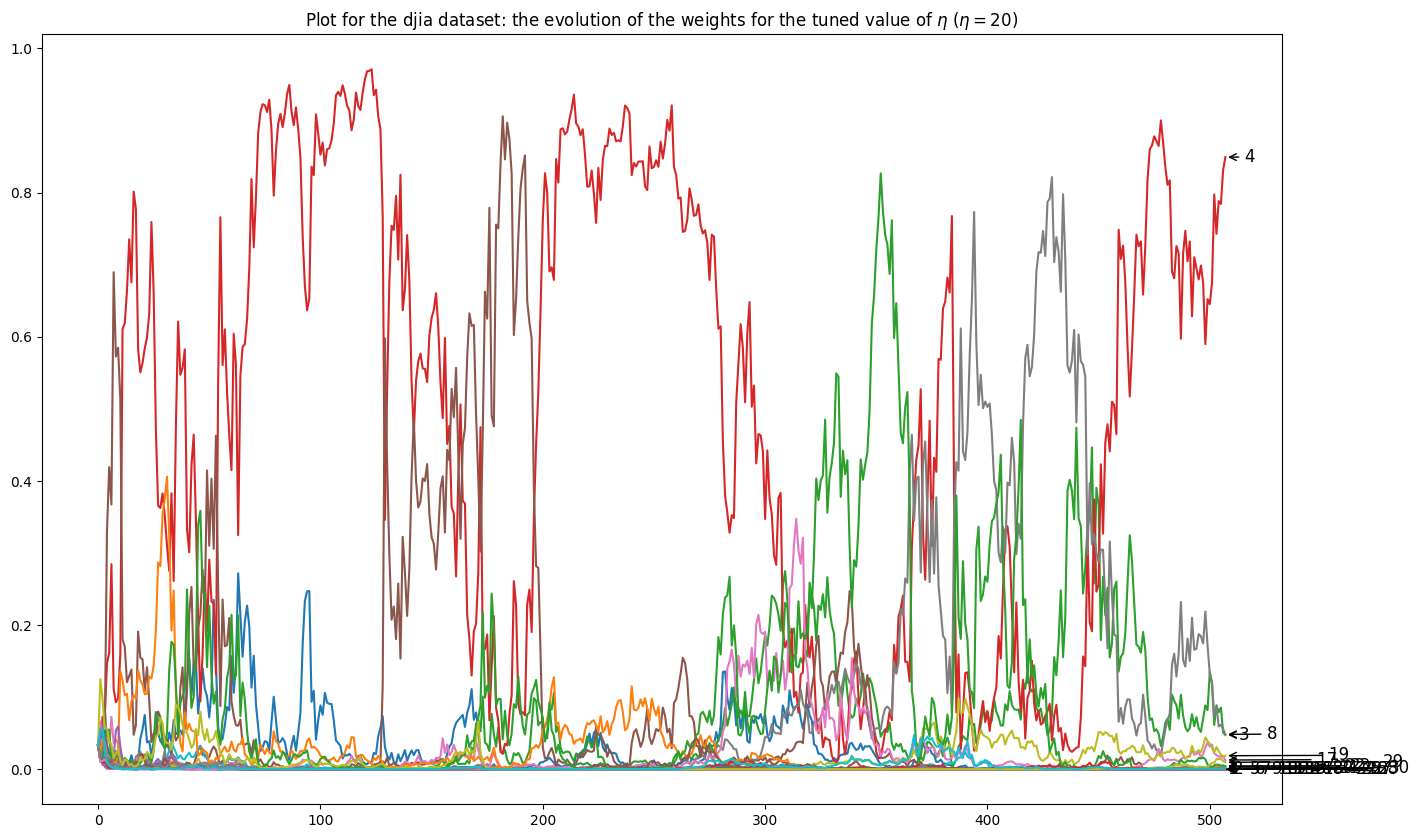

Final Capital: 1.2059413482430437


In [26]:
capital_ewa_djia = {}
name = "djia"
T, d = data[name].shape  # horizon, number of assets
eta_tuned = 20
capital_ewa_djia[name] = 1  # initial capital
capital_ewa_djia, w_djia = use_EWA(name=name, T=T, capital=capital_ewa_djia, eta=eta_tuned, plot_w=True)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the tuned value of $\eta$ ($\eta = 20$)")
plt.show()

capital = final_capital(data["djia"], w_djia[-1])

### Question 5 -- EG
Repeat questions 3 and 4 by using the gradient of the loss (i.e., by using EG) instead of the loss vectors of the experts directly.

Remember, we have that $\ell_t(w_t) := - \log \langle w_t, r_t\rangle =  - \log \sum _{i=1} ^d w_{t,i}  r_{t,i}$

In [11]:
def EG_update(eta, w, grad):
  # eta: learning rate
  # grads: an np.array of shape (d,); vector of gradients of loss in Delta_d; to be updated
  # Returns: an np.array of shape (d,); 

  # ---
  p_updated = w * np.exp(-eta * grad)
  p_updated /= np.sum(p_updated)
  # ---
  return p_updated

In [12]:
capital_eg = {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_EG(name, T, capital, eta=1e-3, plot_w=False, eta_opt_th=False):
    # Initialize the weights
    w = np.full(d, 1/d)  # w_1 of dimension d
    grad_l = lambda r, w: -r / np.sum(r * w)
    g = np.zeros((T, d))

    evolution_w = []
    evolution_w.append(w)
    for day in range(T):  # over horizon T
        # Update capital
        prices = data[name].iloc[day].values
        capital[name] *= np.sum(prices * w)

        # Update the weight vector to redistribute the capital for the next day
        g[day] = np.gradient(grad_l(prices, w))
        
        if eta_opt_th:
            G = np.linalg.norm(prices, ord=2) / prices.min()
            eta = (1 / G) * np.sqrt(np.log(d) / T)
        
        w = EG_update(eta, w, g[day])
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    capital_eg[name] = 1  # initial capital
    capital_eg = use_EG(name=name, T=T, capital=capital_eg)

display(capital_eg)

{'djia': 0.8127178894684374,
 'msci': 0.9268251550587373,
 'nyse-n': 31.348969188433635,
 'nyse-o': 27.079194589194376,
 'sp500': 1.6487718731999454,
 'tse': 1.595241929168324}

$ \max\limits_{w \in \Delta_d} \nabla l_t (w) =  \max\limits_{w \in \Delta_d} \frac{-r}{\langle w, r \rangle} \leq \frac{||r||_2}{ \text{min}(r)} $

In [13]:
capital_eg_theorical_opt = {}

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    #eta_opt = (1 / G) * np.sqrt(np.log(d) / T)
    capital_eg_theorical_opt[name] = 1  # initial capital
    capital_eg_theorical_opt = use_EG(name=name, T=T, capital=capital_eg_theorical_opt, eta=1, plot_w=False, eta_opt_th=False)

display(capital_eg_theorical_opt)

{'djia': 0.8047481126168176,
 'msci': 0.9147031305938623,
 'nyse-n': 22.869535858672492,
 'nyse-o': 27.13422093445256,
 'sp500': 1.7390630777288054,
 'tse': 1.5866130008542296}

Final Capital: 0.8127554907724319


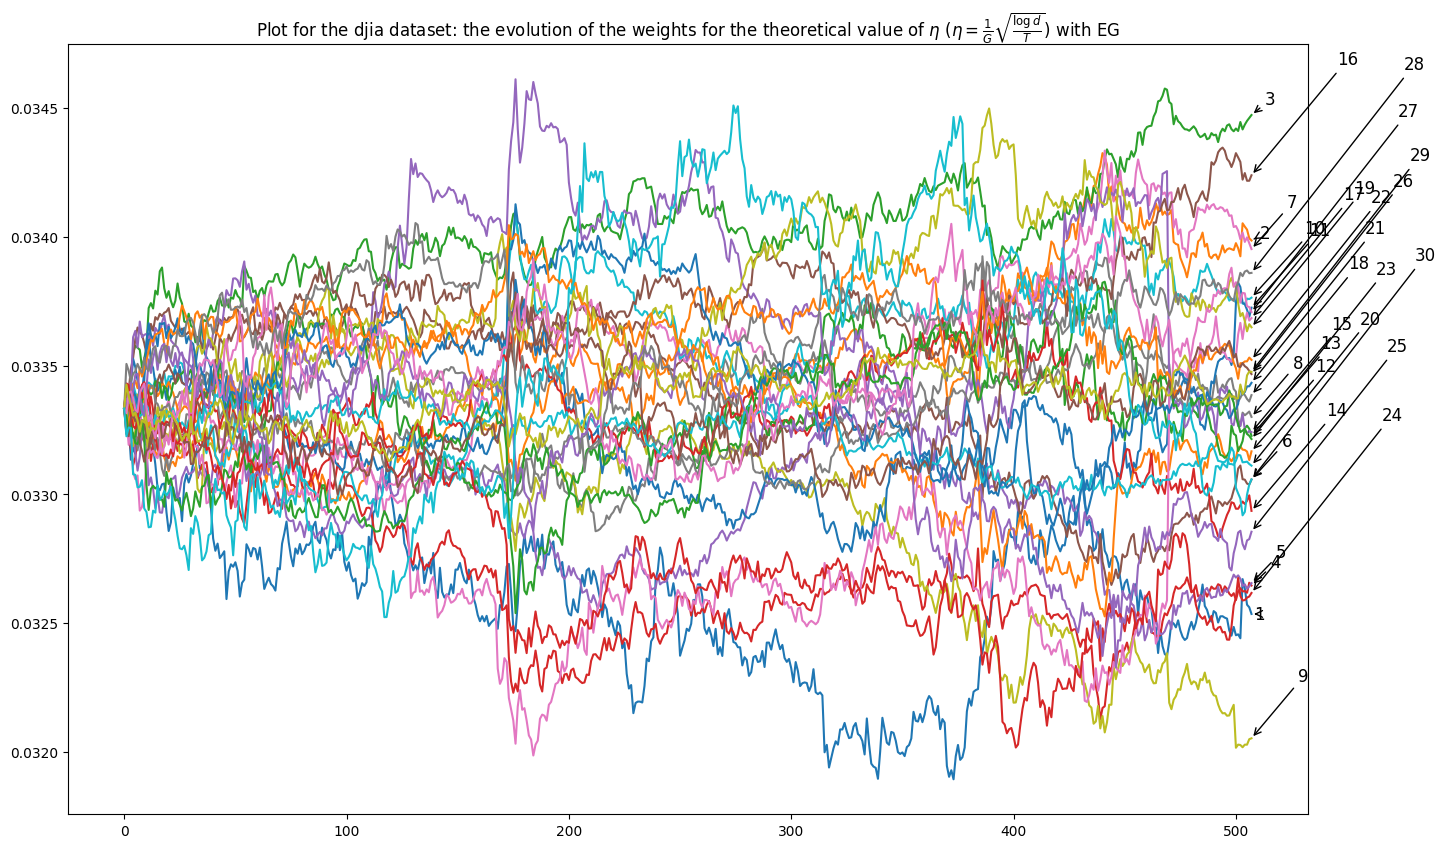

In [27]:
capital_eg_djia = {}
name = "djia"
T, d = data[name].shape  # horizon, number of assets
eta_opt = np.sqrt(np.log(d) / T)
capital_eg_djia[name] = 1  # initial capital
capital_eg_djia, w_djia = use_EG(name=name, T=T, capital=capital_eg_djia, eta=eta_opt, plot_w=True)
capital = final_capital(data["djia"], w_djia[-1])
plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the theoretical value of $\eta$ ($\eta = \frac{1}{G}\sqrt{\frac{\log d}{T}}$) with EG")
plt.show()

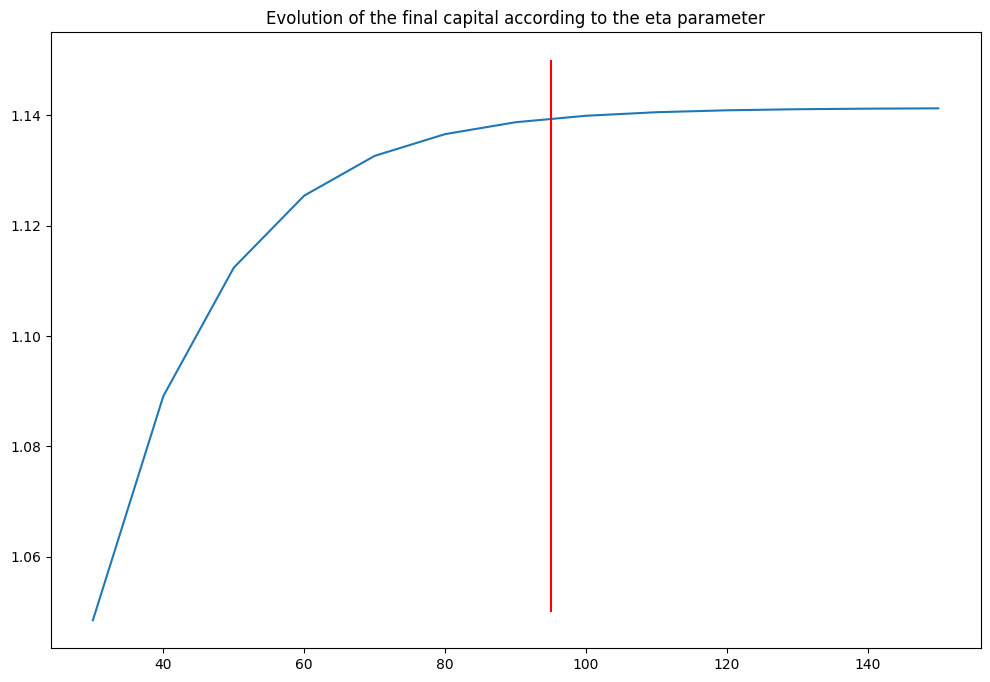

In [46]:
capitals = []
name = "djia"
T, d = data[name].shape  # horizon, number of assets
etas = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
capital = []
for eta in etas:
    capital_ewa_djia[name] = 1  # initial capital
    capital_eg_djia, w_djia = use_EG(name=name, T=T, capital=capital_eg_djia, eta=eta, plot_w=True)
    cap = final_capital(data["djia"], w_djia[-1], verbose=False)
    capitals.append(cap)

plt.figure(figsize=(12,8))
plt.plot(etas, capitals)
plt.vlines(x=95, ymin=1.05, ymax=1.15, color="red")
plt.title("Evolution of the final capital according to the eta parameter")
plt.show()


Final Capital: 0.9765998041887171


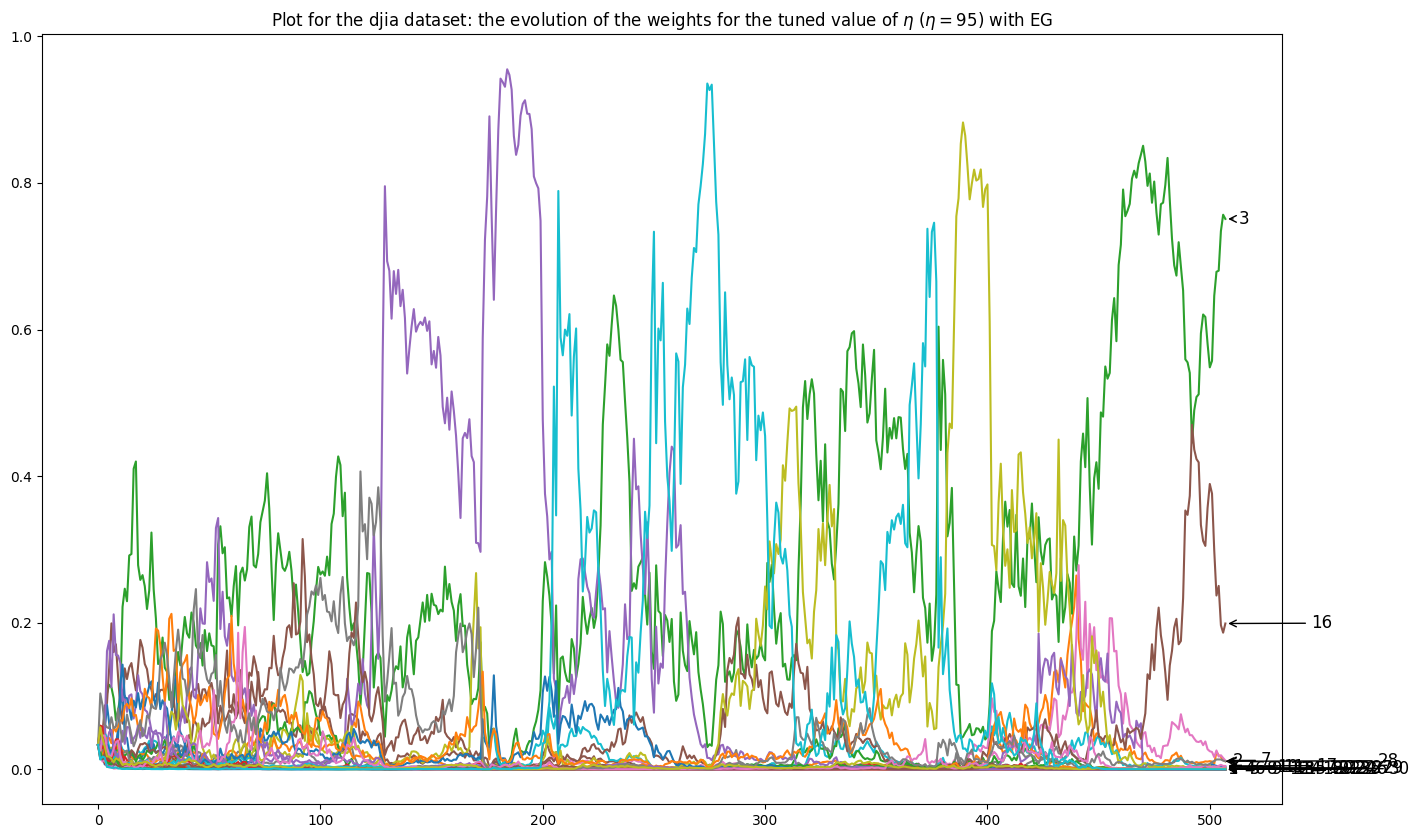

Final Capital: 0.9765998041887171


In [47]:
capital_eg_djia = {}
name = "djia"
T, d = data[name].shape  # horizon, number of assets
eta_tunes = 95
capital_eg_djia[name] = 1  # initial capital
capital_eg_djia, w_djia = use_EG(name=name, T=T, capital=capital_eg_djia, eta=eta_tuned, plot_w=True)
capital = final_capital(data["djia"], w_djia[-1])
plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the tuned value of $\eta$ ($\eta = 95$) with EG")
plt.show()
capital = final_capital(data["djia"], w_djia[-1])

### Question 6 - Projection on the unit simplex

Here is a simple algorithm to implement (Source at the end of the document).

Let $x=\big(x(i)\big)\in\mathbb{R}^M$,
- Sort the coordinates of x into $y_1\geq y_2\geq\dots\geq y_M$,
- Find
$$ \rho=\max\Big\{j\in 1,\dots,M:\ y_j-\frac{1}{j}\big(\sum_{r=1}^jy_r-1\big)>0\Big\},$$
- Define $z = \frac{1}{\rho}\big(\sum_{r=1}^\rho y_r-1\big)$,
- Return, for all $i=1, \dots,M$
$$\big(\Pi_{\Delta_M}(x)\big)(i) = \max\big\{x(i)-z, 0\big\}$$

Define the projection function.


In [15]:
# Projection on the simplex.
def proj_simplex(w):
  # w: vector in R^d
  # Returns: a vector in Delta_d
  
  # ---
  # Sort the coordinates 
  y = np.sort(w)[::-1]
  
  # Find rho 
  cumsum = np.cumsum(y)
  rho = np.argmax( np.arange(1, len(w)+1) * ((y - (cumsum - 1) / np.arange(1, len(w)+1) ) > 0))
  # Define z
  z = (cumsum[rho] - 1) / (rho + 1)
  # ---
  return np.maximum(w - z, 0)

### Question 7 - OGD
Implement the update rule of the Online Gradient Descent algorithm, that take the current weight vector $w_t$, the gradientof $g_t$ and a learning rate and return the new weight vector.

In [16]:
def OGD_update(eta, w, grads):
  # eta: learning rate
  # w: an np.array of shape (d,); vector of weights in Delta_d; to be updated
  # grads: an np.array of shape (d,); vector of gradients of loss in Delta_d; to be updated
  # Returns: an np.array of shape (d,); 

  # ---
  w_updated = proj_simplex(w - eta * grads)
  # ---
  return w_updated

### Question 8 
Repeat questions 3 and 4 with OGD.

In [17]:
capital_OGD = {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_OGD(name, T, capital, eta=1e-3, plot_w=False, eta_practice=False, eta_opt_th=False):
    # Initialize the weights
    w = np.full(d, 1/d)  # w_1 of dimension d
    grad_l = lambda r, w: -r / np.sum(r * w)
    g = np.zeros((T, d))

    evolution_w = []
    evolution_w.append(w)

    for day in range(T):  # over horizon T
        # Update capital
        prices = data[name].iloc[day].values
        capital[name] *= np.sum(prices * w)

        # Update the weight vector to redistribute the capital for the next day
        g[day] = np.gradient(grad_l(prices, w))
        if eta_practice:
            eta = np.sqrt(1 / np.sum(np.linalg.norm(g[:day+1], ord=2, axis=1, keepdims=True)))
        if eta_opt_th:
            G = np.linalg.norm(prices, ord=2) / prices.min()
            eta = np.sqrt(2) / (G * np.sqrt(T))
        w = OGD_update(eta=eta, w=evolution_w[-1], grads=g[day])
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    #eta = np.sqrt(np.log(d) / T)
    capital_OGD[name] = 1  # initial capital
    capital_OGD = use_OGD(name=name, T=T, capital=capital_OGD)


display(capital_OGD)

{'djia': 0.8124807244572122,
 'msci': 0.9265673089461209,
 'nyse-n': 31.171255947642546,
 'nyse-o': 27.217543887112168,
 'sp500': 1.6501644870224759,
 'tse': 1.5966909648224514}

Since $w$ is a weight vector that sums to 1, we have:

$ \max\limits_{w, w' \in \Delta_d} || w - w' || \leq \sqrt{2} \space \text{         }$  and $ \text{         } \max\limits_{w \in \Delta_d} \nabla l_t (w) =  \max\limits_{w \in \Delta_d} \frac{-r}{\langle w, r \rangle} $

Then, we have $ \max\limits_{w \in \Delta_d} \nabla l_t (w) \leq \frac{||r||_2}{ \text{min}(r)}$.

Then, we take $ \eta = \frac{2}{G \sqrt{T}}$

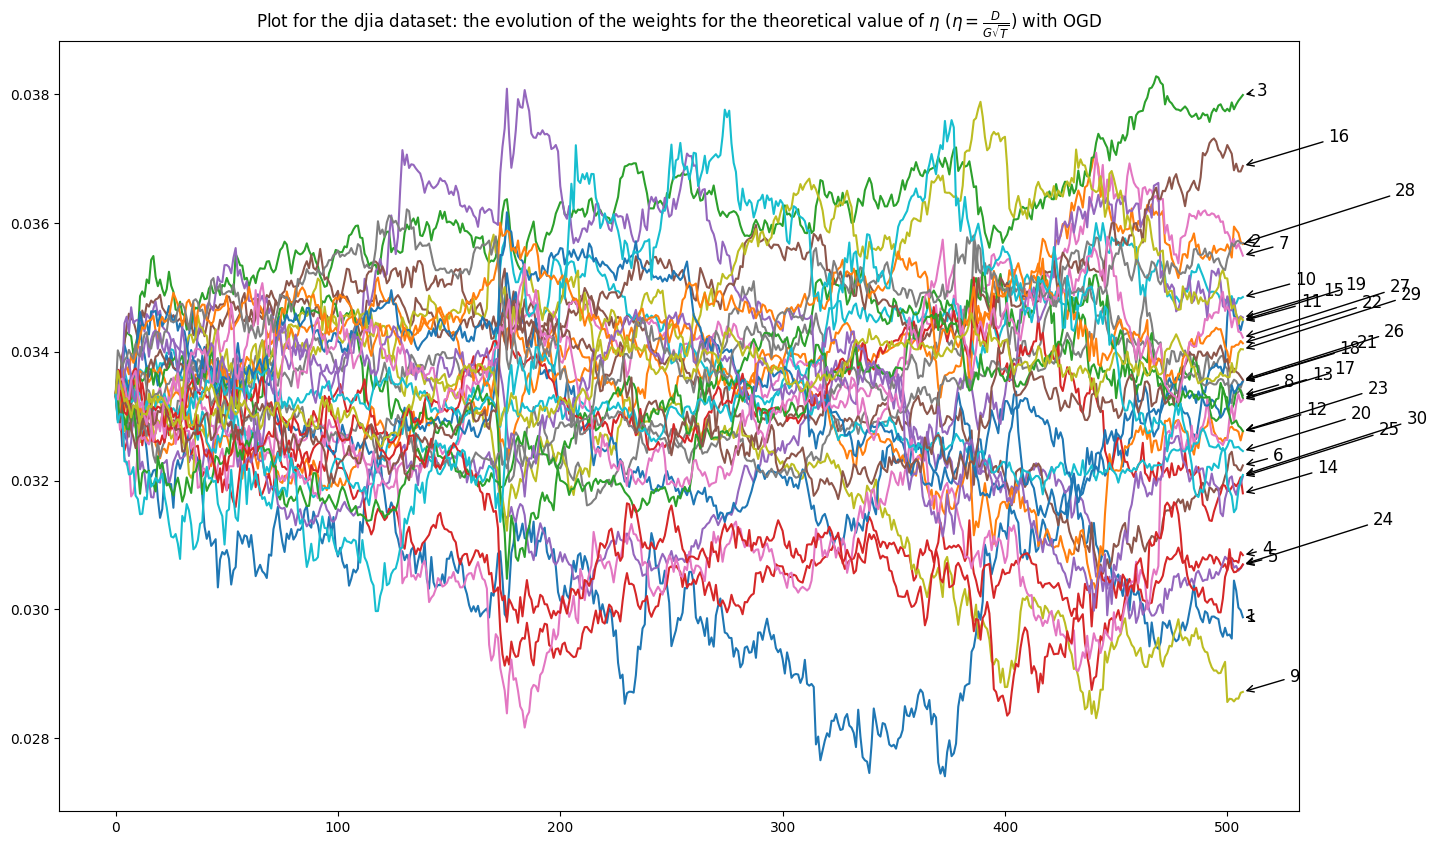

Final Capital: 0.8122375838888398


In [48]:
capital_OGD_djia = {}
name = "djia"
T, d = data[name].shape  # horizon, number of assets
capital_OGD_djia[name] = 1  # initial capital
capital_OGD_djia, w_djia = use_OGD(name=name, T=T, capital=capital_eg_djia, eta=1, plot_w=True, eta_practice=False, eta_opt_th=True)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the theoretical value of $\eta$ ($\eta = \frac{D}{G \sqrt{T}}$) with OGD")
plt.show()
capital = final_capital(data["djia"], w_djia[-1])

### Question 9
Test better solutions to tune the learning rate in practice for OGD. Ideas: use $\eta_t = \sqrt{1/\sum_{s=1}^t \|g_s\|^2}$ for OGD, where $g_s$ is the gradient at time $s$, or define a grid of possible learning rate and use at time $t$ the learning rate that performed the best until round $t-1$.

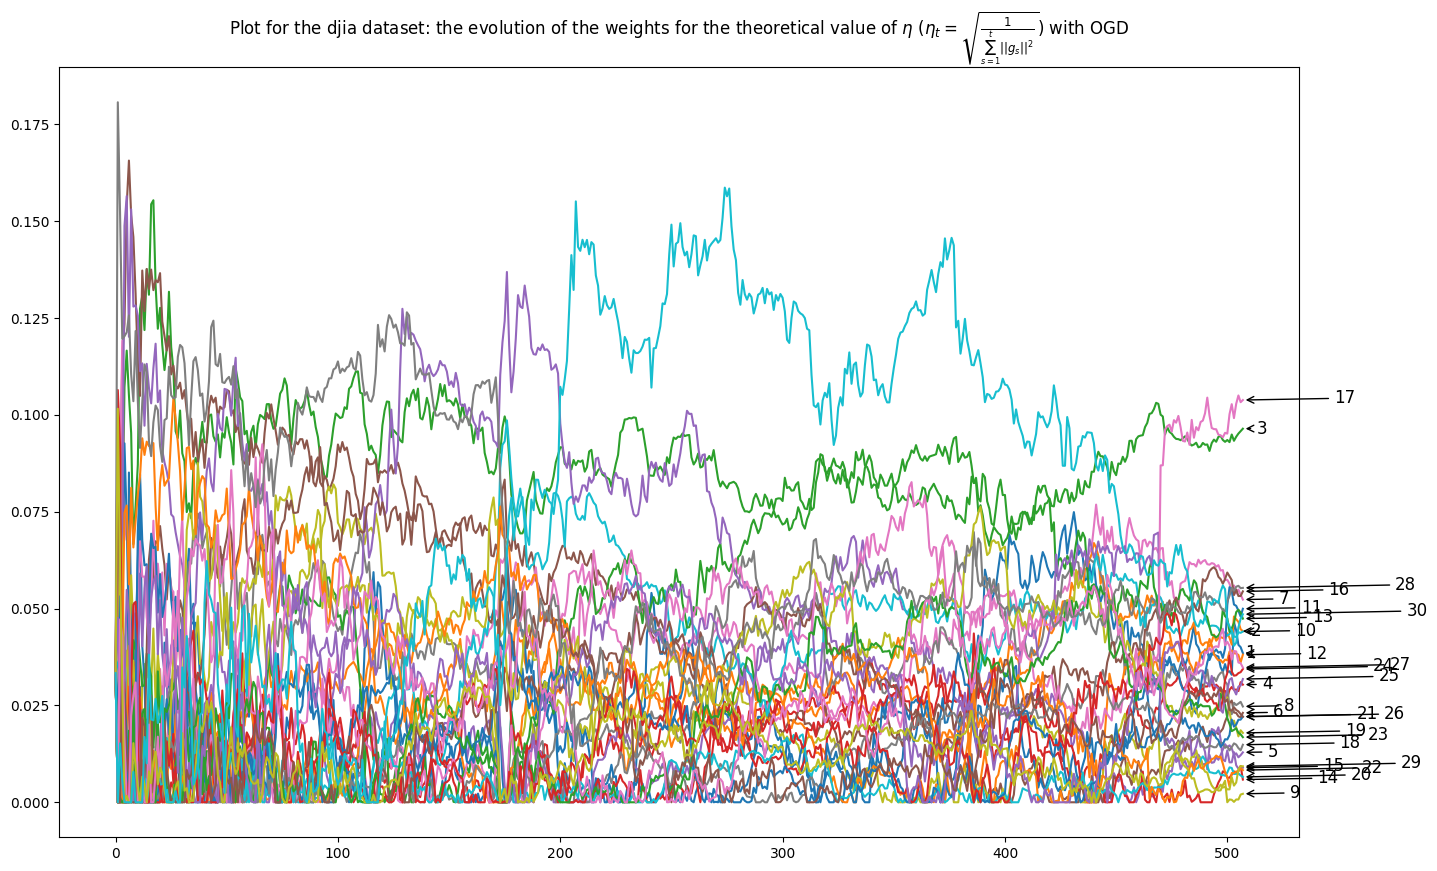

Final Capital: 0.8122375838888398


In [49]:
capital_OGD_djia_eta_not_fix = {}
name = "djia"
T, d = data[name].shape  
capital_OGD_djia_eta_not_fix[name] = 1  
capital_OGD_djia_eta_not_fix, w_djia_not_fix = use_OGD(name=name, T=T, capital=capital_OGD_djia_eta_not_fix, eta=1.0, plot_w=True, eta_practice=True, eta_opt_th=False)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia_not_fix[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia_not_fix) - 1
    y_end = w_djia_not_fix[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the theoretical value of $\eta$ ($\eta_t = \sqrt{ \frac{1}{\sum _{s=1} ^t ||g_s ||^2}}$) with OGD")
plt.show()
capital = final_capital(data["djia"], w_djia[-1])

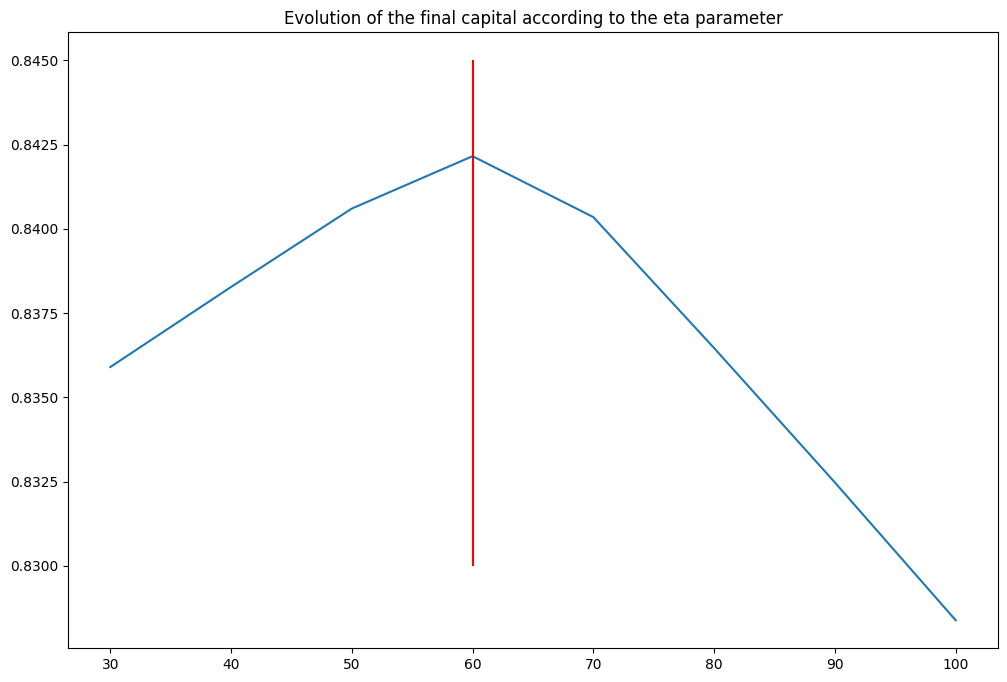

In [56]:
capitals = []
name = "djia"
T, d = data[name].shape  # horizon, number of assets
etas = [30, 40, 50, 60, 70, 80, 90, 100]
capital = []
for eta in etas:
    capital_ewa_djia[name] = 1  # initial capital
    capital_eg_djia, w_djia = use_OGD(name=name, T=T, capital=capital_eg_djia, eta=eta, plot_w=True, eta_practice=False, eta_opt_th=False)
    cap = final_capital(data["djia"], w_djia[-1], verbose=False)
    capitals.append(cap)

plt.figure(figsize=(12,8))
plt.plot(etas, capitals)
plt.vlines(x=60, ymin=0.830, ymax=0.845, color="red")
plt.title("Evolution of the final capital according to the eta parameter")
plt.show()

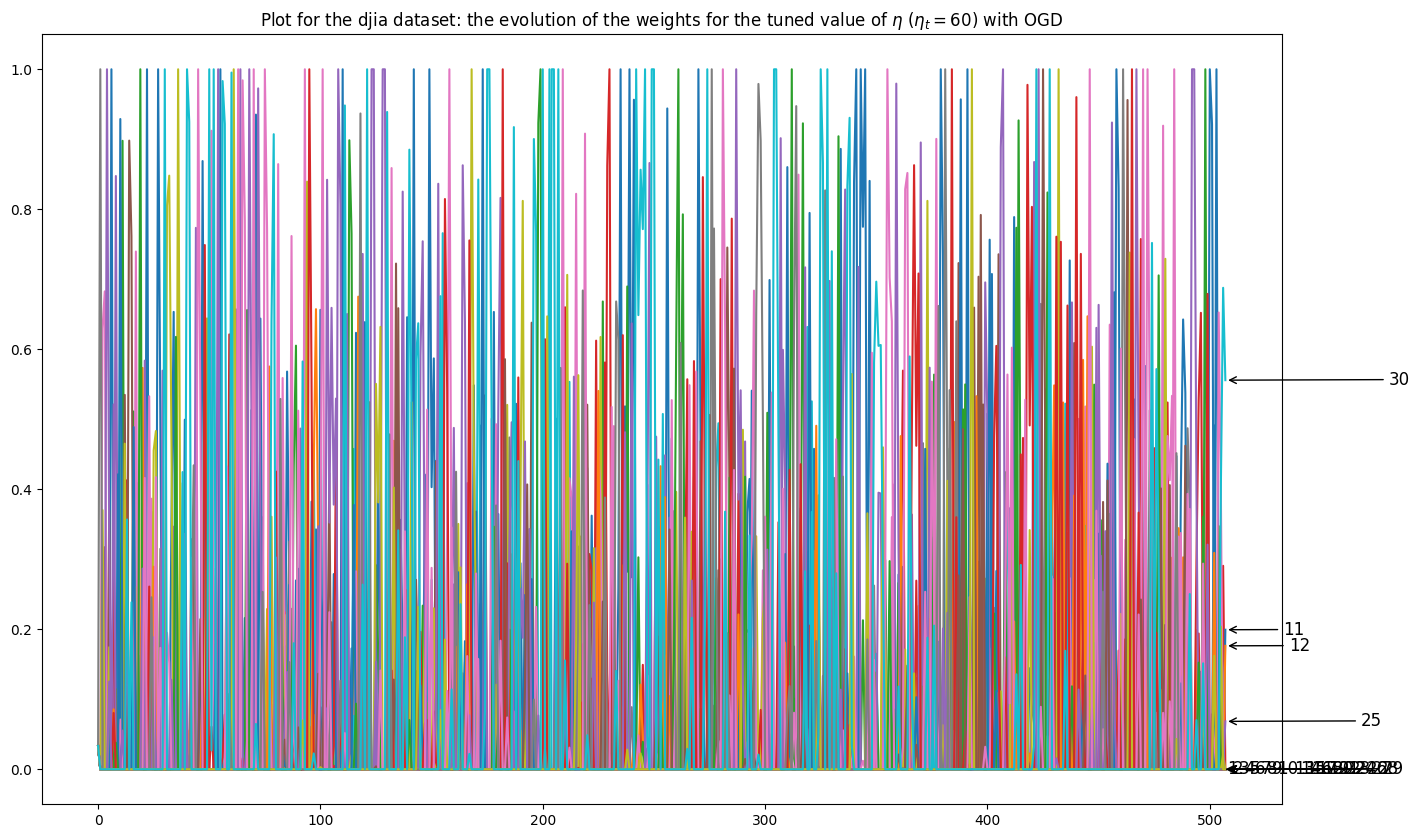

Final Capital: 0.8421542387448195


In [58]:
capital_OGD_djia_tuned = {}
name = "djia"
T, d = data[name].shape  
capital_OGD_djia_tuned[name] = 1  
capital_OGD_djia_tuned, w_djia = use_OGD(name=name, T=T, capital=capital_OGD_djia_tuned, eta=60, plot_w=True, eta_practice=False, eta_opt_th=False)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia) - 1
    y_end = w_djia[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights for the tuned value of $\eta$ ($\eta_t = 60$) with OGD")
plt.show()
capital = final_capital(data["djia"], w_djia[-1])

### Question 10 
What particular curvature property has the loss function here. What would be the regret of ONS compared to OGD or EG?

$ w \mapsto \langle w, r_t\rangle $ is convex, then $ w \mapsto \log \langle w, r_t\rangle ) $ is concave and  $ w \mapsto - \log \langle w, r_t\rangle ) $ is convex.

ONS will have a regret in O($\log T $) which is exponentially better than OGD and EG in convex settings.

### Question 11
Repeat questions 3 and 4 with ONS or OMD with a custom regularization function (you may use convex optimization library to compute the update of the algorithm or the projection). 

In [20]:
def bregman_divergence(psi, psi_grad, x, y):
    """ For any continuously differentiable convex function psi, 
    thus function returns the Bregman divergence with respect to psi """
    psi_x = np.array(psi(x))
    psi_y = np.array(psi(y))
    psi_grad = np.array(psi_grad(y))
    return psi_x - psi_y - psi_grad @ np.array(x - y)

For simplicity, we use the agile version of OMD with the $\text{l}_2$-norm as the regularization function, which allows us to recover the online gradient descent algorithm.

In [21]:
def bregman_divergence_l2(x, y):
    return np.linalg.norm(x-y, ord=2) / 2

def OMD_update(eta, grad_l_theta, grad_psi_theta, agile=True, lazy=False):
    z_up = grad_psi_theta - eta * grad_l_theta
    return proj_simplex(z_up)

In [22]:
capital_OMD = {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_OMD(name, T, capital, psi, grad_psi, eta=1e-3, plot_w=False, agile=True, lazy=False):
    w = np.full(d, 1/d)  
    grad_l = lambda r, w: -r / np.sum(r * w)
    g = np.zeros((T, d))

    evolution_w = []
    evolution_w.append(w)
    for day in range(T):  # over horizon T
        prices = data[name].iloc[day].values
        capital[name] *= np.sum(prices * w)
        g[day] = np.gradient(grad_l(prices, w))
        if agile:
            eta, grad_l_theta, grad_psi_theta = eta, g[day], grad_psi(w)
            w = OMD_update(eta, grad_l_theta, grad_psi_theta, agile=True, lazy=False)
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital

psi = lambda x: np.linalg.norm(x, ord=2) / 2  # with the agile version, we recover the online gradient descent algorithm
grad_psi = lambda x: x

for name in data_names:
    T, d = data[name].shape  # horizon, number of assets
    capital_OMD[name] = 1  
    capital_OMD = use_OMD(name=name, T=T, capital=capital_OMD, psi=psi, grad_psi=grad_psi)


display(capital_OMD)

{'djia': 0.8124807244572122,
 'msci': 0.9265673089461209,
 'nyse-n': 31.171255947642546,
 'nyse-o': 27.217543887112168,
 'sp500': 1.6501644870224759,
 'tse': 1.5966909648224514}

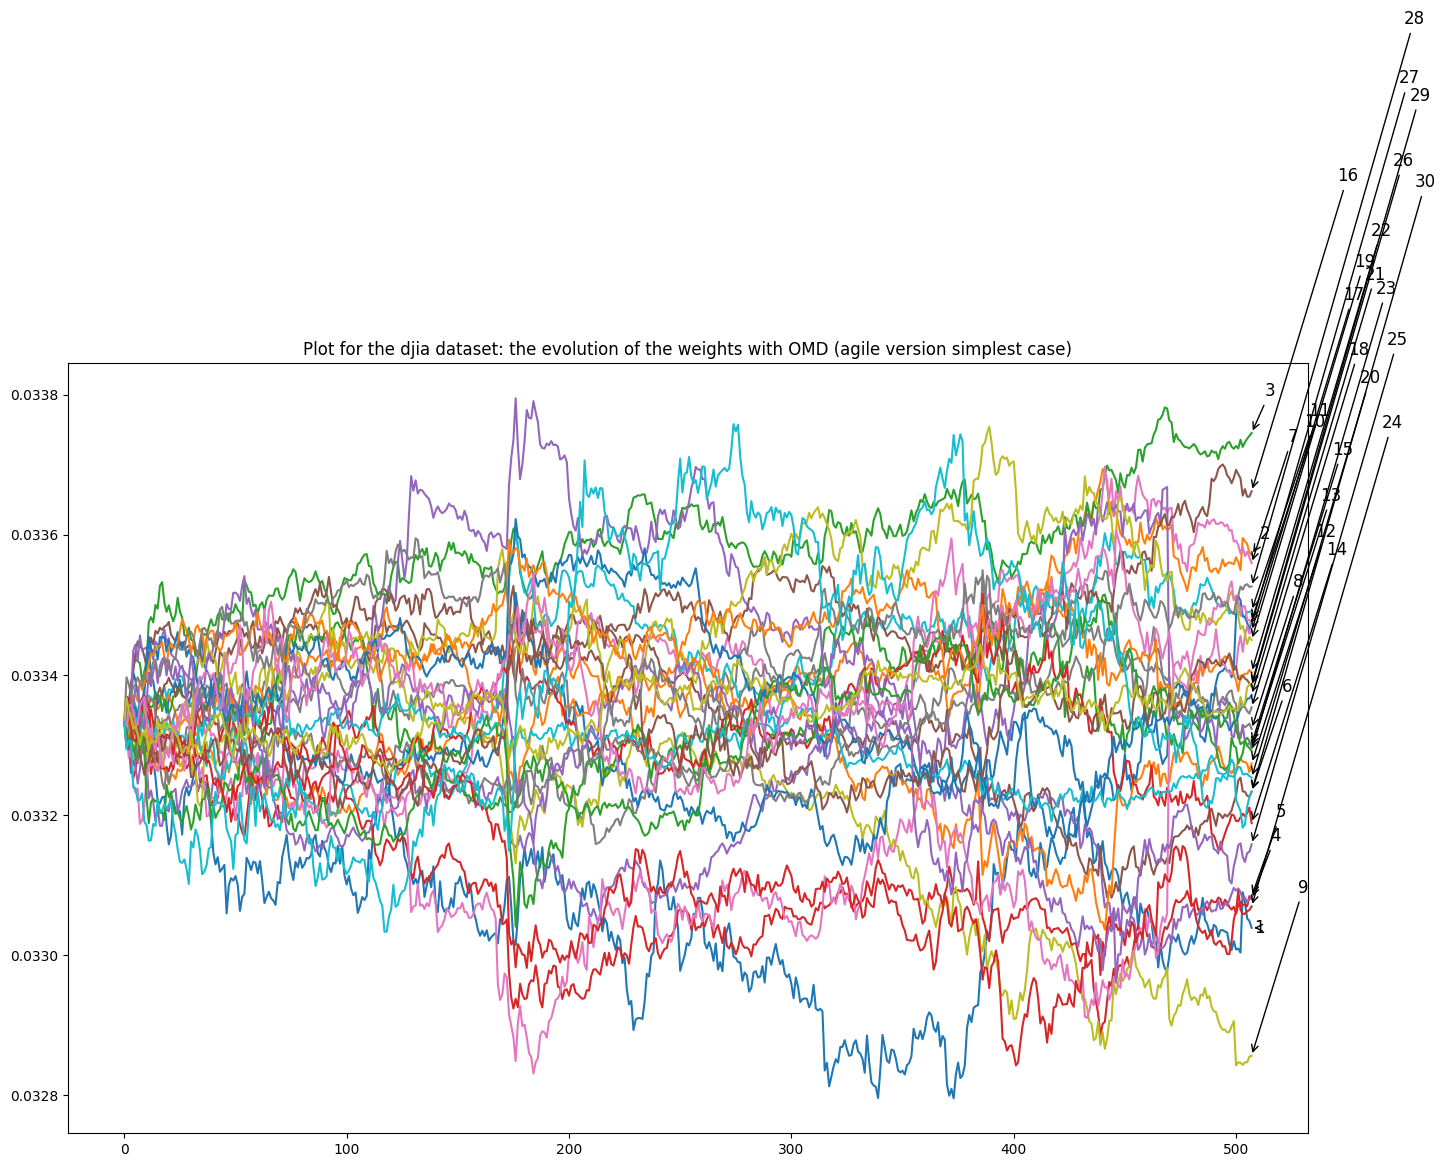

Final Capital: 0.8127384003629722


In [59]:
capital_OMD = {}
name = "djia"
T, d = data[name].shape  
capital_OMD[name] = 1  
capital_OMD, w_djia_not_fix = use_OMD(name, T, capital_OMD, psi, grad_psi, eta=1e-3, plot_w=True, agile=True, lazy=False)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia_not_fix[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia_not_fix) - 1
    y_end = w_djia_not_fix[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights with OMD (agile version simplest case)")
plt.show()
capital = final_capital(data["djia"], w_djia_not_fix[-1])

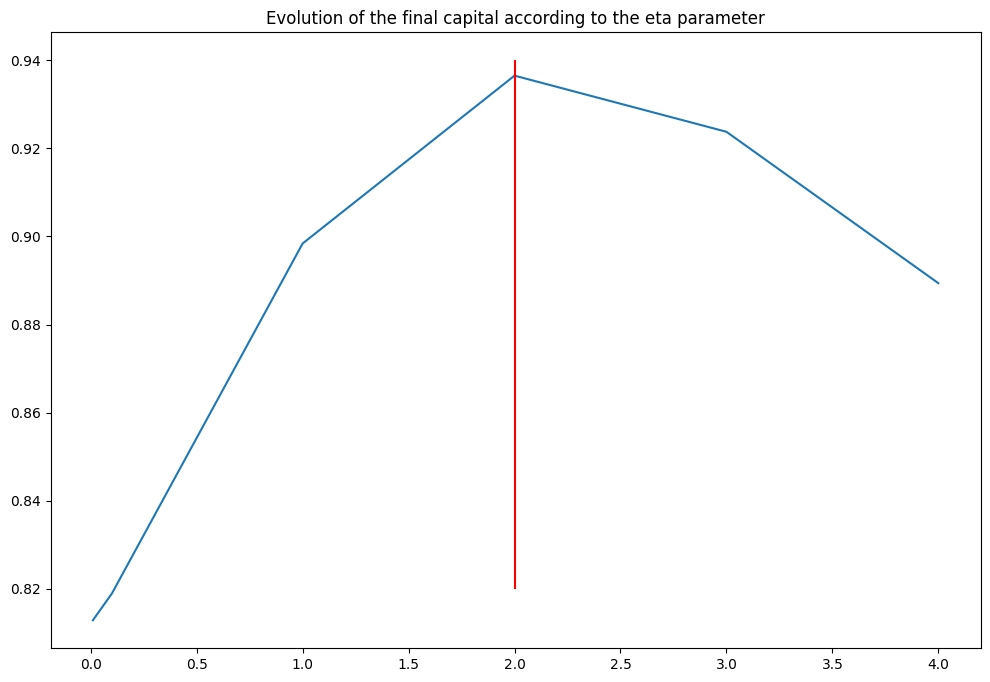

In [64]:
capitals = []
name = "djia"
T, d = data[name].shape  # horizon, number of assets
etas = [0.01, 0.1, 1, 2, 3, 4]
capital = []
for eta in etas:
    capital_ewa_djia[name] = 1  # initial capital
    capital_eg_djia, w_djia = use_OMD(name, T, capital_OMD, psi, grad_psi, eta=eta, plot_w=True, agile=True, lazy=False)
    cap = final_capital(data["djia"], w_djia[-1], verbose=False)
    capitals.append(cap)

plt.figure(figsize=(12,8))
plt.plot(etas, capitals)
plt.vlines(x=2, ymin=0.82, ymax=0.94, color="red")
plt.title("Evolution of the final capital according to the eta parameter")
plt.show()

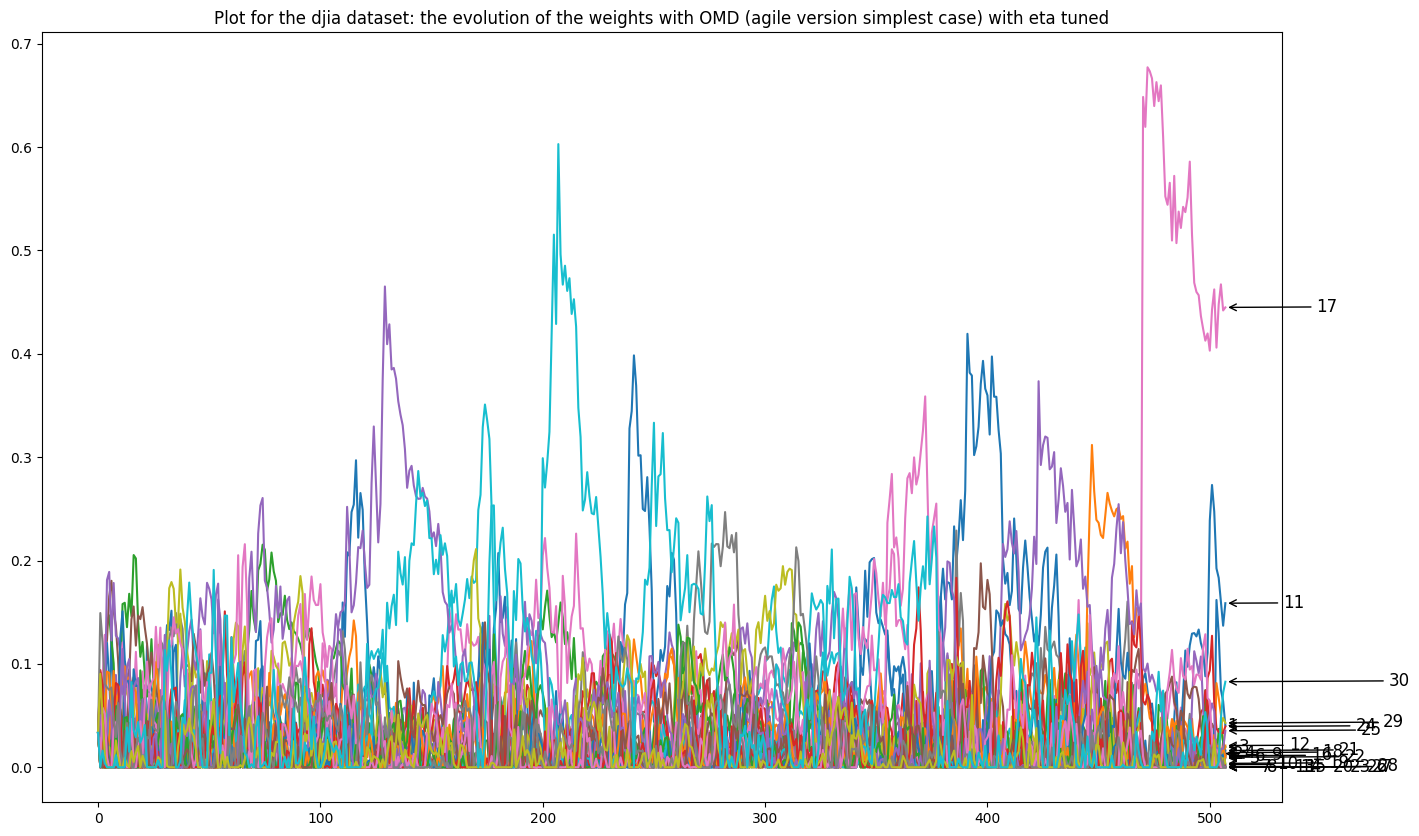

Final Capital: 0.9365113188711176


In [65]:
capital_OMD = {}
name = "djia"
T, d = data[name].shape  
capital_OMD[name] = 1  
capital_OMD, w_djia_not_fix = use_OMD(name, T, capital_OMD, psi, grad_psi, eta=2, plot_w=True, agile=True, lazy=False)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia_not_fix[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia_not_fix) - 1
    y_end = w_djia_not_fix[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights with OMD (agile version simplest case) with eta tuned")
plt.show()
capital = final_capital(data["djia"], w_djia_not_fix[-1])

In [24]:
from scipy.optimize import minimize
from tqdm import tqdm

capital_ONS= {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_ONS(name, T, capital, eta=1e-3, lamb=1e-1, plot_w=False):
    gamma = np.min([eta, 1/4]) / 2
    w = np.full(d, 1/d)  
    grad_l = lambda r, w: -r / np.sum(r * w)
    g = np.zeros((T, d))

    evolution_w = []
    evolution_w.append(w)
    for day in tqdm(range(T)):  # over horizon T
        prices = data[name].iloc[day].values
        capital[name] *= np.sum(prices * w)
        g[day] = np.gradient(grad_l(prices, w))
        to_minimize = lambda theta: np.sum([g[i] @ np.array(theta - evolution_w[i]) + gamma * ((g[i] @ np.array(theta - evolution_w[i]))**2) / 2 + lamb * np.linalg.norm(theta) / 2  for i in list(range(day+1))])
        result = minimize(to_minimize, x0=np.full(d, 1/d))  
        w = result.x     
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital
    

 71%|███████   | 360/507 [05:05<03:52,  1.58s/it]/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_62632/1208441324.py:17: RuntimeWarning: overflow encountered in scalar multiply
  capital[name] *= np.sum(prices * w)
100%|██████████| 507/507 [10:36<00:00,  1.26s/it]


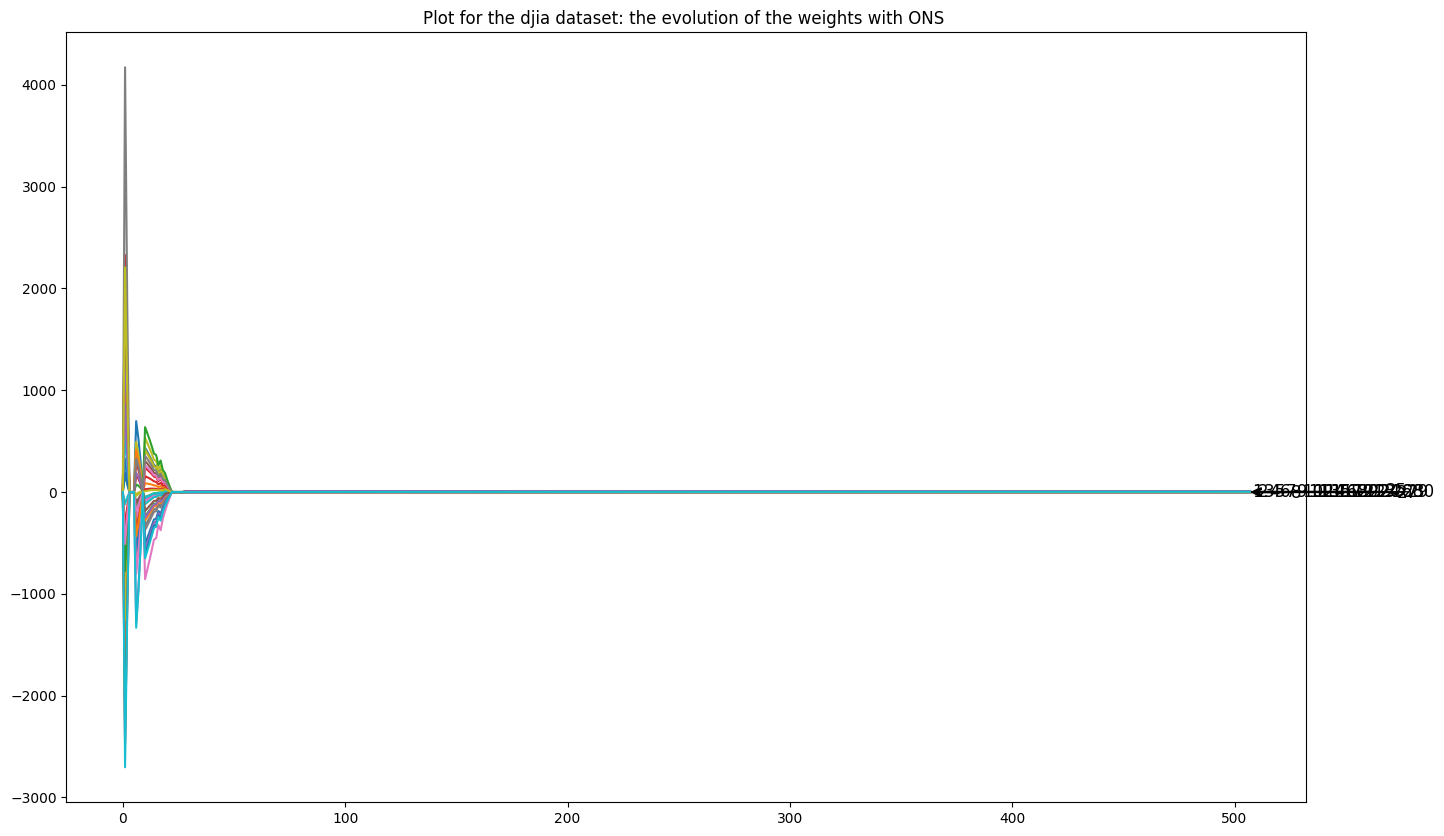

Final Capital: -2.3130019118901618e+238


In [66]:
capital_ONS = {}
name = "djia"
T, d = data[name].shape  
capital_ONS[name] = 1  
capital_ONS, w_djia_not_fix = use_ONS(name, T, capital_ONS, eta=1e-3, lamb=1e-1, plot_w=True)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_djia_not_fix[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_djia_not_fix) - 1
    y_end = w_djia_not_fix[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights with ONS ")
plt.show()
capital = final_capital(data["djia"], w_djia_not_fix[-1])

### Question 12
Print a table summarizing the final capital obtained by the best asset, the best fixed rebalanced portfolio, and the different algorithms (each for the best learning rate tuned on data and the theoretical value).

#### Summary of Final Capital for Different Strategies

| **Dataset** | **Best Asset** | **Best Fixed Rebalanced** | **EWA (Tuned)** | **EWA (Theoretical)** | **EG (Tuned)** | **EG (Theoretical)** | **OGD (Tuned)** | **OGD (Theoretical)** | **OMD (Tuned)** | **OMD (Theoretical)** |
|------------|-------------|-----------------------|------------------|-------------------|----------------|------------------|------------------|------------------|------------------|------------------|
| **DJIA**   | 1.188360   | 1.239928              | 1.2059           | 0.8173            | 0.9766         | 0.8128           | 0.8422           | 0.8122           | 0.9365           | 0.8127           |
| **MSCI**   | 1.504023   | 1.505693              | X.XX             | X.XX              | X.XX           | X.XX             | X.XX             | X.XX             | X.XX             | X.XX             |
| **NYSE-N** | 83.506698  | 120.320907            | X.XX             | X.XX              | X.XX           | X.XX             | X.XX             | X.XX             | X.XX             | X.XX             |
| **NYSE-O** | 54.140364  | 250.585000            | X.XX             | X.XX              | X.XX           | X.XX             | X.XX             | X.XX             | X.XX             | X.XX             |
| **SP500**  | 3.779182   | 4.068627              | X.XX             | X.XX              | X.XX           | X.XX             | X.XX             | X.XX             | X.XX             | X.XX             |
| **TSE**    | 6.279220   | 6.779988              | X.XX             | X.XX              | X.XX           | X.XX             | X.XX             | X.XX             | X.XX             | X.XX             |



###### Notes:
- **EWA**: Exponentially Weighted Average
- **EG**: Exponential Gradient
- **OGD**: Online Gradient Descent
- **ONS**: Online Newton Step
- **OMD**: Online Mirror Descent
- The **best learning rate** is tuned using data, while the **theoretical learning rate** follows theoretical bounds.


### Question 13 (optional) -- Bandit feedback
We now assume that each day, the trader only observes its updated captital at each round $\mathrm{Cap}_{t}$ and has no access to the vectors $r_t$. Implement OGD with no gradient to select your portfolio in this case and display you final capitals. 

For $ t = 1, \dots, T $:

1. Draw $ u_t \in \mathbb{S} $ uniformly at random from the unit sphere.
2. Set $\hat{\theta} _t= \theta + \delta u _t $, a random perturbation of the current point $\theta_t $.
3. Play $ \theta_b $.
4. Estimate the gradient at $ \theta_t $ with: $\hat{g} _t = \frac{d}{\gamma} \text{l} _t ( \hat{\theta} _t ) u_t$
5. Update $ \theta $ within the constrained set: $ \theta _{t+1} = \text{Proj}_{\Theta_{\delta}} (\theta _t - \eta \hat{g} _t)$ where $ \Theta_{\delta} =  ( \theta \in \Theta \mid \theta + \delta u \in \Theta, \forall u \in \mathbb{S} )$


In [74]:
capital_bandit = {}
data_names = ["djia","msci","nyse-n","nyse-o","sp500","tse"]

def use_bandit_feedback(name, T, capital, eta=1e-3, gamma=1, delta=1e-1, plot_w=False):
    gamma = np.min([eta, 1/4]) / 2
    w = np.full(d, 1/d)  
    evolution_w = []
    evolution_w.append(w)

    for day in tqdm(range(T)):  # over horizon T
        prices = data[name].iloc[day].values
        capital[name] *= np.sum(prices * w)
        u = np.random.uniform(size=d)
        w_hat = np.array(w + delta * u)
        gradient_hat = - d * np.log(prices @ w_hat) * u / gamma
        w_updated = proj_simplex(w - eta * gradient_hat) 
        w = w_updated
        evolution_w.append(w)
    if plot_w:
        return capital, np.array(evolution_w)
    else:
        return capital

100%|██████████| 507/507 [00:00<00:00, 22067.50it/s]


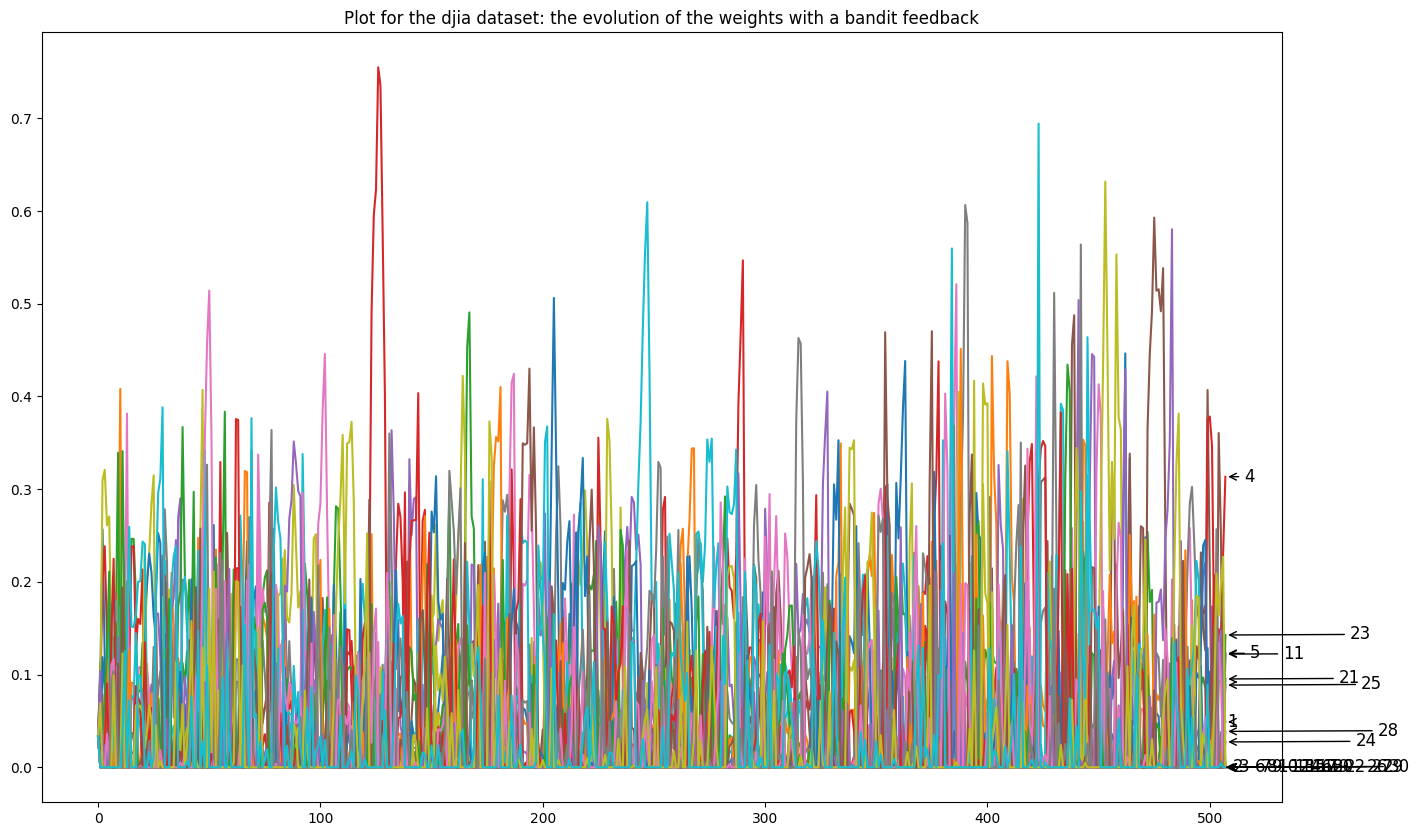

In [94]:
capital_bandit = {}
name = "djia"
T, d = data[name].shape  
capital_bandit[name] = 1  
capital_bandit, w_bandit = use_bandit_feedback(name, T, capital_bandit, eta=1e-4, gamma=d*10000, delta=1e-5, plot_w=True)

plt.figure(figsize=(16,10))
for asset in range(d):
    plt.plot(w_bandit[:, asset], label=f"asset number {asset+1}")
    x_end = len(w_bandit) - 1
    y_end = w_bandit[x_end, asset]
    plt.annotate(f"{asset+1}",
                 xy=(x_end, y_end), 
                 xytext=(x_end + 1 + 2.5 * asset, y_end + 0.00003 * asset),  
                 arrowprops=dict(arrowstyle="->", lw=1),
                 fontsize=12, ha="left", va="center")
#plt.legend(loc="lower left")
plt.title(r"Plot for the djia dataset: the evolution of the weights with a bandit feedback")
plt.show()

# References
- Duchi, J., Shalev-Shwartz, S., Singer, Y., & Chandra, T. (2008, July). Efficient projections onto the l 1-ball for learning in high dimensions. In Proceedings of the 25th international conference on Machine learning (pp. 272-279).